# Load Model Performance Assessment
In this NoteBook the accuracy of the load model as implemented in the paper is tested against a perfect load model for the solar disaggregation task. The perfect load model means that the real value of the load is fit as a regressor.

### Results:

In [4]:
# Solar Disaggregation extended validation
import sys
sys.path.append("..") # Adds higher directory to python modules path.
from copy import deepcopy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import csss
import matplotlib.pyplot as plt
import datetime as dt
import pickle as pk
from imp import reload
import copy
from time import time as t_clock
from copy import deepcopy
import seaborn as sns
from csss.SolarDisagg import createTempInput
from csss.utilities import Setup_load as SetUp_load
from csss.utilities import save_pkl, load_pkl

In [5]:
## Loading the data

Setup_load = deepcopy(SetUp_load())
Setup_load.QueryOrLoad()
load_data, load_data_2, weather, grouped_data, ids, solar_ids, homeids  = Setup_load.load_setup()

reading 61047030 values from csv took 8.06 seconds
There are 167 homes with complete data
105 homes solar
62 homes with no solar


In [6]:
## Remove those solar houses that have generation = 0 for continous N_obs.
N_obs_day = 96 # number of observations in one day.
N_obs = 3*N_obs_day
remove = []
for i in solar_ids['solar']:
    df = grouped_data.get_group(i)
    roll_mean = df.gen.rolling(N_obs).mean()
    if np.nansum(roll_mean < 0.001) > 0:
        remove.append(i)
len(remove)

## Update the data accordingly
ids = list(set(ids) - set(remove))
load_data = load_data[~load_data['dataid'].isin(remove)]
solar_ids['solar'] = list(set(solar_ids['solar']) - set(remove))
solar_ids['nosolar'] = list(set(solar_ids['nosolar']) - set(remove))

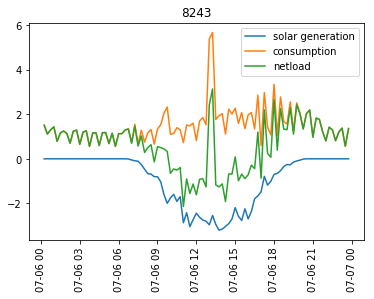

In [7]:
## Do a quick plot of load data
fig = plt.figure()
ax = plt.gca()
# np.random.seed(6)
dataid = np.random.choice(grouped_data.mean().index, size=1)[0]
data = load_data.groupby('dataid').get_group(dataid)
start = dt.datetime(2015,7,6)
dur   = dt.timedelta(days = 1)
ind = (data.index > start) & (data.index < start + dur)
data = data.loc[ind,:]

ax.plot(data.index,-data['gen'], label = 'solar generation')
ax.plot(data.index,data['use'], label = 'consumption')
ax.plot(data.index,data['netload'], label = 'netload')
ax.set_title(dataid)
ax.legend()
plt.xticks(rotation = 90)
plt.show()

In [5]:
def run_scenario_perfect_load(Nhomes,Nproxies, Ndays, Ntunesys, Nsolar):
    ## Identify dataids to use
    if Ntunesys > Nproxies:
        print('Error: it must be Ntunesys <= Nproxies ')
        return
    solarids = np.random.choice(solar_ids['solar'], Nsolar+Nproxies, replace=False)
    proxyids = solarids[:Nproxies]   # Homes to be used as solar proxy
    solids  = solarids[Nproxies:]    # Homes with solar 
    nosolids   = np.random.choice(solar_ids['nosolar'], Nhomes-Nsolar, replace=False)    # Homes without solar. 
    homeids = np.concatenate([solids,nosolids]) # Homes used for solar disagg
    tuneids  = homeids[:Ntunesys]  # Home to be used for tuning
    dataids = np.concatenate([solarids,nosolids]) # Ids for all the systems
    
    ## Set up data 
    first = True
    for did in dataids:
        dat = load_data.groupby("dataid").get_group(did)[['use','gen']]
        if did in solarids:
            dat['gen'] = -dat['gen']
        else:
            dat['gen'] = 0
        dat['netload_%s' % did] = dat['use'] + dat['gen']
        dat.columns = ['demand_%s' % did, 'solar_%s' % did, 'netload_%s' % did]

        if first:
            fulldata = dat
            first = False
        else:
            fulldata = pd.concat([fulldata,dat], axis = 1)

    ## Create aggregate load and aggregate net load columns. 
    netloadcols = ['netload_%s' % d for d in homeids]
    loadcols    = ['demand_%s' %  d for d in homeids]
    proxycol    = ['solar_%s' %   d for d in proxyids]

    fulldata['AggregateNetLoad'] = np.sum(fulldata[netloadcols], axis = 1)
    fulldata['AggregateLoad']    = np.sum(fulldata[loadcols], axis = 1)
    fulldata['Date'] = [dt.datetime(t.year, t.month, t.day, 0, 0, 0) for t in fulldata.index]
        
    ## Time align weather data with load data using linear interpolation 
    xp  = [t.value for t in weather.index]
    x = [t.value for t in fulldata.index]
    fulldata['AustinTemp'] = np.interp(x = x ,xp=xp, fp =  weather['temperature'])

    ## Get indices for Ndays random dates
    dates = fulldata[['Date','AggregateLoad']].groupby('Date').count()   ### Find number of readings for each date
    numel = dates['AggregateLoad']                                      
    dates = dates.index[numel == np.max(numel)]                          ### Choose only dates with complete readings
#     dates = dates[ np.random.choice(np.arange(len(dates)), replace=False, size=Ndays) ] ### Randomly select Ndays dates
    start_sequence = int(np.random.choice(np.arange(len(dates)-Ndays), replace=False, size=1))
    dates = dates[start_sequence:start_sequence+Ndays] ### select continous Ndays dates
    induse = fulldata['Date'].isin(dates)  ### Subset data
    data = fulldata.loc[induse,:]

    ## Get HOD regressors
    hod = pd.Series([t.hour for t in data.index])
    hod = pd.get_dummies(hod)

    ## Get temperature regressors
    Tmin, Tmax, tempregress = regressor=createTempInput(data['AustinTemp'], 10)

    ## Prepare data for ingestion into SolarDisagg method. 
#    loadregressors = deepcopy(np.hstack([hod,tempregress]))
    netload = np.array(data[netloadcols])
    solarproxy = np.array(data[proxycol])
    names = ['solar_%s' % d for d in homeids]        

    ## Construct solar disaggregation problem
###### Test if the model improves when the load itself is used as a regressor. Perfect Info. I want to see which value of Theta is attributed and the alpha parameter too.
    loadregressors = deepcopy(np.expand_dims(data['AggregateLoad'].values, axis = 1)) # I do not include a bias term too becuase then I want to see the Theta Value.     
#    loadregressors = deepcopy(np.hstack([hod,tempregress]))
    reload(csss.SolarDisagg)
    sdmod0 = copy.deepcopy(csss.SolarDisagg.SolarDisagg_IndvHome(netloads=netload, solarregressors=solarproxy, loadregressors=loadregressors, tuningregressors = hod, names = names))

    ## add true vectors
    for d in homeids:
        source_name = 'solar_%s' % d
        sdmod0.addTrueValue(name=source_name, trueValue=data[source_name])

    ## Add true aggregate load
    sdmod0.addTrueValue(name = 'AggregateLoad', trueValue=data['AggregateLoad'])

    ## Construct and solve the problem. 
    sdmod0.constructSolve(solver = None)#'GUROBI')
    sdmod_tune = copy.deepcopy(sdmod0)
    sdmod_tune.fitTuneModels(['solar_%s' % d for d in tuneids])
    sdmod_tune.tuneAlphas()
    sdmod_tune.constructSolve(solver = None)#'GUROBI')

##### Comparison with a tuned model using the standard loadregressor
    loadregressors = deepcopy(np.hstack([hod,tempregress]))
    reload(csss.SolarDisagg)
    sdmod_tune_std = copy.deepcopy(csss.SolarDisagg.SolarDisagg_IndvHome(netloads=netload, solarregressors=solarproxy, loadregressors=loadregressors,tuningregressors = hod, names = names))
    ## add true vectors
    for d in homeids:
        source_name = 'solar_%s' % d
        sdmod_tune_std.addTrueValue(name=source_name, trueValue=data[source_name])

    ## Add true aggregate load
    sdmod_tune_std.addTrueValue(name = 'AggregateLoad', trueValue=data['AggregateLoad'])

    ## Construct and solve the problem. 
    sdmod_tune_std.constructSolve(solver = None)# 'GUROBI')
    sdmod_tune_std.fitTuneModels(['solar_%s' % d for d in tuneids])
    sdmod_tune_std.tuneAlphas()
    sdmod_tune_std.constructSolve(solver = None)#'GUROBI')


    outdict = {}
    outdict['tuned_model'] = sdmod_tune
    outdict['initial_model'] = sdmod0
    outdict['tuned_model_std'] = sdmod_tune_std
    outdict['dates'] = dates
    outdict['times'] = data.index
    outdict['proxyids'] = proxyids
    outdict['homeids']  = homeids
    outdict['tuneids']  = tuneids
    outdict['solids']  = solids
    outdict['nosolids']  = nosolids
    outdict['data']  = data
    return(outdict)

In [6]:
#%% Create Output Data Frame
def create_outputdf(scen_out, name = 'output' ,scen_n = 1):
    mod = scen_out['tuned_model']
    
    scen_out['initial_model'].calcPerformanceMetrics()
    scen_out['tuned_model'].calcPerformanceMetrics()
    scen_out['tuned_model_std'].calcPerformanceMetrics()
    df0 = scen_out['initial_model'].performanceMetrics
    dft = scen_out['tuned_model'].performanceMetrics
    dfs = scen_out['tuned_model_std'].performanceMetrics
    
    
    df0['tuned'] = 'ini'
    dft['tuned'] = 'tune'
    dfs['tuned'] = 'tune_std'
    df0['tuned_temp'] = 'ini' # I need it for the index
    dft['tuned_temp'] = 'tune' # I need it for the index
    dfs['tuned_temp'] = 'tune_std' # I need it for the index
    dfout = pd.concat([df0,dft,dfs])
    
    dfout['scen_name'] = name
    dfout['dataid']    = 0
    dfout['N_sys']     = len(mod.models)-1
    dfout['N_read']    = len(mod.aggregateSignal)
    dfout['N_prox']    = 0
    dfout['N_tunesys'] = len(scen_out['tuneids'])
    dfout['istunesys'] = False
    dfout['frac_reverse'] = np.ones(dfout.shape[0]) * np.nan
    dfout['isSolar']   = False
    dfout['scen']    = scen_n
    
    dfout = dfout.reset_index().set_index(['models','tuned'])
    for did in scen_out['homeids']:
        for tuned in list(['ini','tune','tune_std']):
            name = 'solar_' + str(did)
            dfout.loc[(name,tuned),'frac_reverse'] = np.mean( mod.netloads[name] < 0 )
            dfout.loc[(name,tuned),'N_prox'] = mod.models[name]['regressor'].shape[1]
            dfout.loc[(name,tuned),'dataid'] = np.int(did)
            dfout.loc[(name,tuned),'istunesys'] = (did in scen_out['tuneids'])
            dfout.loc[(name,tuned),'isSolar'] = (did in scen_out['solids'])
    
    
    dfout = dfout.reset_index().set_index(['dataid','N_sys','tuned_temp','scen'])        
    index = pd.MultiIndex.from_tuples(dfout.index.values.tolist(), names=['dataid', 'N_houses','tuning','scen'])
    dfout.set_index(index,inplace = True)
    return(dfout)   

Let's run an example

In [8]:
## Select the parameters
Nhomes = 10
Nproxies = 2
Ndays = 10
Ntunesys = 2
Nsolar = int(Nhomes/2)

scen_out = run_scenario_perfect_load(Nhomes,Nproxies, Ndays, Ntunesys, Nsolar)
df_out   = create_outputdf(scen_out)

The value of the Theta coefficient in the aggregated load model is  1.0071043261284585


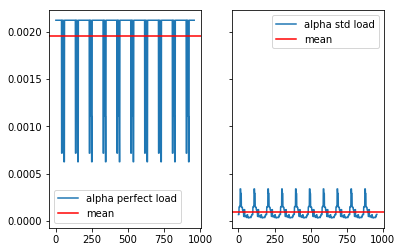

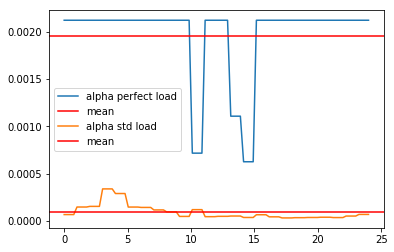

Average alpha ratio Perfect_Load/Std_Load =  31.550421647745058


In [50]:
## Plot the alpha behaviour
models = ['tuned_model','tuned_model_std'] 
models_title = ['perfect load','std load']
#models = ['initial_model','tuned_model'] 
alphas = pd.DataFrame(columns = models)
fig, ax = plt.subplots(nrows=1, ncols=2, sharey = True)
fig2,ax2= plt.subplots(nrows=1, ncols=1)
for i in range(len(models)):
    sdmod = deepcopy(scen_out[models[i]])
    if models[i] == 'tuned_model':
        print('The value of the Theta coefficient in the aggregated load model is ',sdmod.models['AggregateLoad']['theta'].value)
#    plt.subplots(1,3,i+1)
    ax[i].plot(sdmod.models['AggregateLoad']['alpha'], label = 'alpha '+models_title[i])
    ax[i].axhline(y = sdmod.models['AggregateLoad']['alpha'].mean(), label = 'mean', color = 'red')
    ax[i].legend()
    
    ax2.plot(np.linspace(0,24,96),sdmod.models['AggregateLoad']['alpha'][0:96], label = 'alpha '+models_title[i])
    ax2.axhline(y = sdmod.models['AggregateLoad']['alpha'].mean(), label = 'mean', color = 'red')
    ax2.legend()
    
    
    alphas[models[i]] = sdmod.models['AggregateLoad']['alpha']
plt.show()
print('Average alpha ratio Perfect_Load/Std_Load = ',np.mean(alphas['tuned_model']/alphas['tuned_model_std']))

### Performance evaluation over a larger sample

The simulation has been run for 8,30,60 houses where half of them have solar installed. 
The metric I focused on is cv_pos: cv when the real solar production is higher than 5% of the mean. Same metric chosen by MT.
Ndays = 10, Nproxy = 2, Ntunesys = 2.

In [20]:
## Perform the validation 
N_houses = [8,30,60]
N_scenarios = 30
error = pd.Series(0,index=N_houses)
index = []
for i in range(N_scenarios):
    for j in range(len(N_houses)):
        index.append((i,j))
alphas = pd.DataFrame(columns = ['perfect','standard'], index = pd.MultiIndex.from_tuples(index))
df_all = pd.DataFrame()
for i in range(N_scenarios):
    for j in range(len(N_houses)):
        Nhomes = N_houses[j]
        Nproxies = 2
        Ndays = 30
        Ntunesys = 2
        Nsolar = int(Nhomes/2)
        t1 = t_clock()        
        try:
            scen_out = run_scenario_perfect_load(Nhomes,Nproxies, Ndays, Ntunesys, Nsolar)
        except:
            df_out = pd.DataFrame()
            error.loc[Nhomes] += 1
            
        else:
            ## Create output dfs
            df_out = create_outputdf(scen_out, scen_n = i)
        t2 = t_clock()
        print('It took {} minutes to solve {} days.'.format((t2-t1)/60,Ndays))
        df_all = pd.concat([df_all,df_out])
        alphas.loc[(i,j)] = [scen_out['tuned_model'].models['AggregateLoad']['alpha'].mean(),scen_out['tuned_model_std'].models['AggregateLoad']['alpha'].mean()]
        print('{}% completed'.format((i+1)/N_scenarios*100))
        fp = '../Validation/data/perfect_load_model_30Ndays'
#         save_pkl([df_all,error],fp+'.pkl')
        

It took 0.3312484224637349 minutes to solve 30 days.
3.3333333333333335% completed
saved results in  ../Validation/data/perfect_load_model_30Ndays.pkl
It took 1.9566346923510234 minutes to solve 30 days.
3.3333333333333335% completed
saved results in  ../Validation/data/perfect_load_model_30Ndays.pkl
It took 5.175016446908315 minutes to solve 30 days.
3.3333333333333335% completed
saved results in  ../Validation/data/perfect_load_model_30Ndays.pkl
It took 0.3606529792149862 minutes to solve 30 days.
6.666666666666667% completed
saved results in  ../Validation/data/perfect_load_model_30Ndays.pkl
It took 1.7186274131139119 minutes to solve 30 days.
6.666666666666667% completed
saved results in  ../Validation/data/perfect_load_model_30Ndays.pkl
It took 1.091915198167165 minutes to solve 30 days.
6.666666666666667% completed
saved results in  ../Validation/data/perfect_load_model_30Ndays.pkl
It took 0.30178234179814656 minutes to solve 30 days.
10.0% completed
saved results in  ../Validati

It took 0.42590781847635906 minutes to solve 30 days.
66.66666666666666% completed
saved results in  ../Validation/data/perfect_load_model_30Ndays.pkl
It took 2.178509060541789 minutes to solve 30 days.
66.66666666666666% completed
saved results in  ../Validation/data/perfect_load_model_30Ndays.pkl
It took 1.6274643460909526 minutes to solve 30 days.
66.66666666666666% completed
saved results in  ../Validation/data/perfect_load_model_30Ndays.pkl
It took 0.39308759768803914 minutes to solve 30 days.
70.0% completed
saved results in  ../Validation/data/perfect_load_model_30Ndays.pkl
It took 2.3607905745506286 minutes to solve 30 days.
70.0% completed
saved results in  ../Validation/data/perfect_load_model_30Ndays.pkl
It took 5.097670761744181 minutes to solve 30 days.
70.0% completed
saved results in  ../Validation/data/perfect_load_model_30Ndays.pkl
It took 0.5045024315516154 minutes to solve 30 days.
73.33333333333333% completed
saved results in  ../Validation/data/perfect_load_model_3

In [9]:
## Load the results
with open('../Validation/data/perfect_load_model_results'+'.pkl', 'rb') as f:
    [df_all,alphas,N_houses,N_scenarios,Nproxies,Ndays,Ntunesys,Nsolar] = pk.load(f)

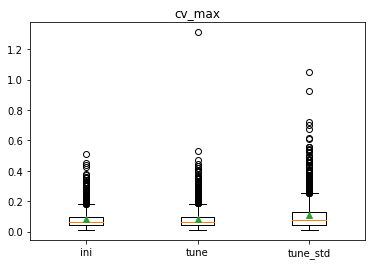

Boxplot stats:
            ini      tune  tune_std
means  0.080781  0.085064  0.110723
Comments: the plots show quite some outliers. However looking at the mean, the perfect load model does a better job. The error of the perfect load model is means    23.17
dtype: float64 % lower than the standard one.


In [15]:
def keep_not_nan(x):
    return x[~np.isnan(x)]

def exctract_metric(bp,metric = 'means'):
    ## bp boxplot object
    ## metric = 'means','medians'
    x = []
    for medline in bp['means']:
        linedata = medline.get_ydata()
        x.append(linedata[0])
    return x
    
bp_metric = 'means'
models = ['ini','tune','tune_std'] 
metrics = ['cv_max']#,'mbe_pos']

for j in range(len(metrics)):
    box_vectors = []
    for i in range(len(models)):
        box_vectors.append(keep_not_nan(df_all.loc[df_all.index.levels[0][1:],df_all.index.levels[1],models[i],df_all.index.levels[3]][metrics[j]][df_all['istunesys'] == False].values))
    plt.figure()
    bp = plt.boxplot(box_vectors,labels = models, showmeans = True)
    plt.title(metrics[j])
    plt.show()

df_boxplot = pd.DataFrame(columns = models, data = np.expand_dims(exctract_metric(bp,bp_metric),axis = 0),index = [bp_metric])
print('Boxplot stats:')
print(df_boxplot)
gain = 100*(1-np.abs(df_boxplot['tune']/df_boxplot['tune_std']))
print('Comments: the plots show quite some outliers. However looking at the mean, the perfect load model does a better job. The error of the perfect load model is {} % lower than the standard one.'.format(round(gain,2)))

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

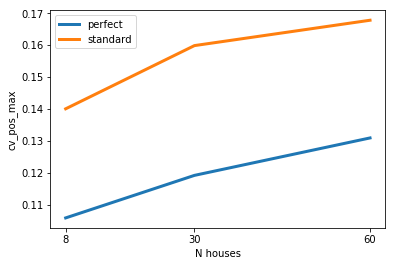

In [14]:
## Plot the average metric as a function of N_houses
models = ['tune','tune_std'] 
for j in range(len(metrics)):
    df = pd.DataFrame(columns = models,index = N_houses)
    for i in range(len(models)):
        plt.figure()
        for k in range(len(N_houses)):
            if metrics[j] == 'rmse':
                df.loc[N_houses[k],models[i]] = np.abs(np.mean(keep_not_nan(df_all.loc[df_all.index.levels[0][1:],df_all.index.levels[1][k],models[i],df_all.index.levels[3]][metrics[j]][df_all['istunesys'] == False].values)))
            else:
                df.loc[N_houses[k],models[i]] = np.mean(keep_not_nan(df_all.loc[df_all.index.levels[0][1:],df_all.index.levels[1][k],models[i],df_all.index.levels[3]][metrics[j]][df_all['istunesys'] == False].values))
    df.plot(linewidth = 3)
    plt.legend(['perfect','standard'])
    plt.xticks(N_houses)
    plt.ylabel(metrics[j])
    plt.xlabel('N houses')
plt.show()
# plt.savefig('figures/cv_pos_perfect_load_comparison_N.png',bbox_inches = 'tight')

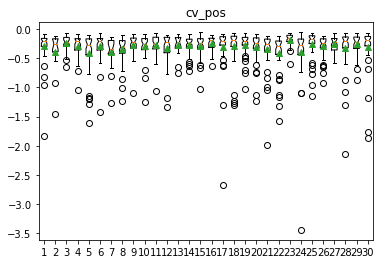

In [93]:
## Plot to show that there are outliers in each scenario scetting and it is not sistematic
bb = []
for n_scen in df_all.index.levels[3]:
    bb.append(keep_not_nan(df_all.loc[df_all.index.levels[0][1:],df_all.index.levels[1],models[1],n_scen][metrics[j]][df_all['istunesys'] == False]))
plt.figure()
bbb = plt.boxplot(bb,range(30), showmeans = True)
plt.title(metrics[j])
plt.xlabel('N scenarios')
plt.show()

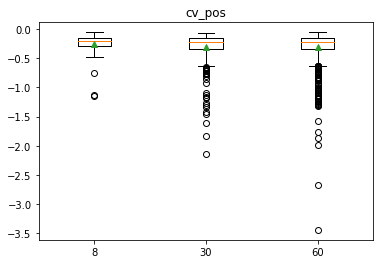

In [94]:
## Boxplot as a function of number of houses - It seems the outliers are all concentrated on the 30 and 60. It is probably because there are much more houses involved, and more likely to get the bad ones.
bb = []
for n_houses in df_all.index.levels[1]:
    bb.append(keep_not_nan(df_all.loc[df_all.index.levels[0][1:],n_houses,models[1],df_all.index.levels[3]][metrics[j]][df_all['istunesys'] == False]))
plt.figure()
bbb = plt.boxplot(bb,labels = [a for a in df_all.index.levels[1]], showmeans = True)
plt.title(metrics[j])
plt.show()

It seems the outliers are all concentrated on the 30 and 60. It is probably because there are much more houses involved, and more likely to get the bad ones. It could also be that having the tuning systems inside the aggregate load model, it is easier to identify the load pattern having only 8 houses.

Overall average ratio at each point in time
10.213698251887367
Overall average ratio
3.4755207171624365


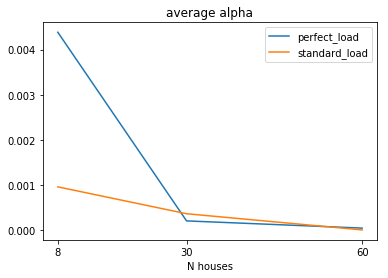

In [69]:
## Plot average alpha magnitude as a function of the N_houses
p_list = []
s_list = []
for j in range(len(N_houses)):
#     data = (alphas.loc[(range(N_scenarios),j),'perfect']/alphas.loc[(range(N_scenarios),j),'standard']).mean()
    p_list.append(alphas.loc[(range(N_scenarios),j),'perfect'].mean())
    s_list.append(alphas.loc[(range(N_scenarios),j),'standard'].mean())

plt.plot(N_houses,p_list, label = 'perfect_load')
plt.plot(N_houses,s_list, label = 'standard_load')
plt.xticks(N_houses)
plt.xlabel('N houses')
plt.title('average alpha')
plt.legend()

print('Overall average ratio at each point in time')
print((alphas['perfect'].values/alphas['standard'].values).mean())
print('Overall average ratio')
print(alphas['perfect'].values.mean()/alphas['standard'].values.mean())